In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ardl import ardl_select_order
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

### Read data

In [284]:

# Read data
uncertainty = pd.read_csv('../data/processed/uncertainty_index.csv')
etf_price = pd.read_csv('../data/processed/etf_price.csv')

# Merge the data
data = pd.merge(uncertainty,etf_price,on='Period')

# Convert 'Period' to datetime
data['Period'] = pd.to_datetime(data['Period'])

# Create a new column 'etf_diff' representing the difference (lagged by 1 period) 
data['etf_diff'] = data['etf_price'].diff()
data.dropna(inplace=True)

# Keep only the necessary columns
data = data[['Period', 'uncertainty' , 'etf_diff']]


In [285]:
# Display a concise summary of the DataFrame
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 160 entries, 1 to 160
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Period       160 non-null    datetime64[ns]
 1   uncertainty  160 non-null    float64       
 2   etf_diff     160 non-null    float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 5.0 KB
None


### Plot the trend of STNSU & ETF

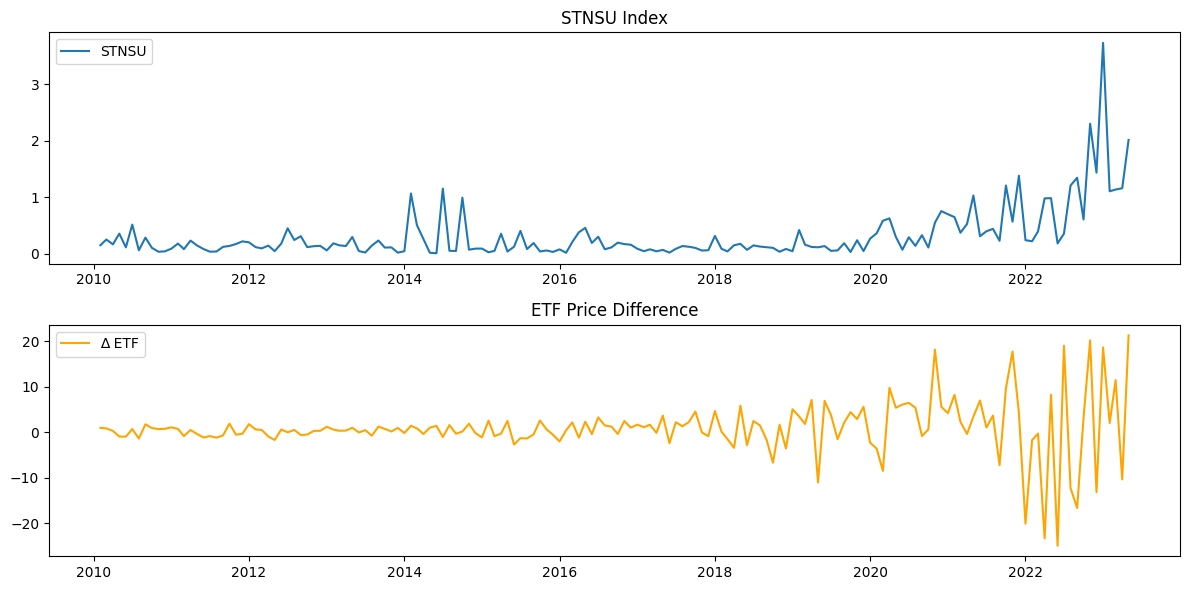

In [286]:

# Set 'Period' as the index
data.set_index('Period', inplace=True)

# Create the figure and subplots
plt.figure(figsize=(12, 6))

# Plot STNSU index
plt.subplot(2, 1, 1)
plt.plot(data['uncertainty'], label='STNSU')
plt.title('STNSU Index')
plt.legend()

# Plot ETF price difference
plt.subplot(2, 1, 2)
plt.plot(data['etf_diff'], label='∆ ETF', color='orange')
plt.title('ETF Price Difference')
plt.legend()

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


### Model


Stationarity

In [287]:

# Function to test stationarity using the Augmented Dickey-Fuller (ADF) Test
def test_stationarity(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

# Test stationarity for ETF price difference
print("Testing etf_diff:")
test_stationarity(data['etf_diff']) # reject the null hypothesis and conclude that the series is stationary.

print("\nTesting uncertainty:")
test_stationarity(data['uncertainty']) # non-stationary


Testing etf_diff:
ADF Statistic: -3.5259403068312207
p-value: 0.007345354941696817

Testing uncertainty:
ADF Statistic: 2.854449981893027
p-value: 1.0


Cointegration


In [295]:

# Test stationarity using the Engle-Granger approach
# Perform OLS regression: Regress X (non-stationary) on Y (stationary)
X = sm.add_constant(data['uncertainty'])  # Add a constant term for the intercept
model = sm.OLS(data['etf_diff'], X)
result = model.fit()

# Get residuals from the regression
residuals = result.resid

# Perform ADF test on residuals to check for stationarity
adf_test = adfuller(residuals)

# Print results
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])

# Interpretation
if adf_test[1] < 0.05:
    print("The residuals are stationary, suggesting cointegration between X and Y.")
else:
    print("The residuals are non-stationary, suggesting no cointegration between X and Y.")


ADF Statistic: -3.656905604472182
p-value: 0.00476180746088372
Critical Values: {'1%': -3.4759527332353084, '5%': -2.881548071241103, '10%': -2.577438765246763}
The residuals are stationary, suggesting cointegration between X and Y.


ARDL model

In [298]:

# Set target and feature data
Y = data['etf_diff']
X = data['uncertainty']

# Selecting the optimal lag order for ARDL
selected_model = ardl_select_order(endog=data['etf_diff'], maxlag=10, exog=data[['uncertainty']], maxorder=10, ic='bic')

# Fit the ARDL model with selected lags
ardl_model = selected_model.model.fit()
print(ardl_model.summary())


                              ARDL Model Results                              
Dep. Variable:               etf_diff   No. Observations:                  160
Model:                     ARDL(1, 0)   Log Likelihood                -502.645
Method:               Conditional MLE   S.D. of innovations              5.711
Date:                Sat, 17 Aug 2024   AIC                           1013.290
Time:                        02:34:56   BIC                           1025.566
Sample:                    03-01-2010   HQIC                          1018.275
                         - 05-01-2023                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0665      0.561      0.119      0.906      -1.041       1.174
etf_diff.L1       -0.2604      0.078     -3.356      0.001      -0.414      -0.107
uncertainty.L0     3.2295      0.980